Consruction of SMB and MOM so that the two factors are neutralized with each other Fama-French style.

In [40]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd, YearEnd
import datetime as dt
import matplotlib.pyplot as plt
import os
os.chdir("/Users/charlesrambo/Desktop/QIII/Quantitative Asset Management")

In [41]:
# Load stock information
stocks = pd.read_csv("stocks.csv")

In [42]:
# Record CRSP unkowns
unknowns = ["-66.0", "-77.0", "-88.0", "-99.0", "-99.99", "-999", "A", "B", "C", "D", "E", "S", "T", "P"]

# Create function to convert CRISP unkowns to np.nan
convert_unknows = lambda x: np.nan if x in unknowns else x

In [43]:
# Convert date column to date-time object
stocks['date'] = pd.to_datetime(stocks['date'], format = '%Y%m%d')

# Record observations where both returns and delisting returns are missing
stocks['flag'] = stocks['RET'].isna() & stocks['DLRET'].isna()

# Fill missing returns with 0
stocks['RET'] = stocks['RET'].apply(convert_unknows).astype(float).fillna(0)

# Fill missing delisting returns with 0
stocks['DLRET'] = stocks['DLRET'].apply(convert_unknows).astype(float).fillna(0)

# Compute log returns of the product
stocks['RET'] = np.log((1 + stocks['RET']) * (1 + stocks['DLRET']))

#Make stale prices positive
stocks['PRC'] = stocks['PRC'].abs()

# Remove 0 priced observations
stocks = stocks.loc[stocks['PRC'] > 0]

# Remove non-psitive shares outstanding
stocks = stocks.loc[stocks['SHROUT'] > 0]

# Only consider stocks listed on the big exchanges
stocks = stocks.loc[stocks['SHRCD'].isin([10, 11]) & stocks['EXCHCD'].isin([1, 2, 3])]

# Drop unneeded columns
stocks.drop(['DLRET', 'SHRCD', 'EXCHCD', 'PERMCO'], axis = 1, inplace = True)

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [44]:
# Calculate market equity
stocks['ME'] = stocks['PRC'] * stocks['SHROUT']

# Short values for shift
stocks.sort_values(by = ['PERMNO', 'date'], inplace = True)

# Record the shifts which are valid
stocks['Isvalid'] = stocks['date'] + MonthEnd(0) == stocks['date'].shift(1) + dt.timedelta(days = 7) + MonthEnd(0)
stocks.loc[stocks['Isvalid'] == True, 'Isvalid'] = stocks.loc[stocks['Isvalid'] == True, 'PERMNO'] == stocks.loc[stocks['Isvalid'] == True, 'PERMNO'].shift(1)

# Shift market equity
stocks['ME_lag'] = stocks[['PERMNO', 'ME']].groupby('PERMNO')['ME'].shift(1)

# Replace the invalids with nan
stocks.loc[stocks['Isvalid'] == False, 'ME_lag'] = np.nan

# Drop unneeded columns
stocks.drop(['ME', 'Isvalid'], axis = 1, inplace = True)

In [45]:
# Sort values again for another shift
stocks.sort_values(by = ['PERMNO', 'date'], inplace = True)

# Check to see if valid
stocks['Isvalid'] = stocks['date'] + MonthEnd(0) == stocks['date'].shift(12) + dt.timedelta(days = 7) + MonthEnd(12)
stocks.loc[stocks['Isvalid'] == True, 'Isvalid'] = stocks.loc[stocks['Isvalid'] == True, 'PERMNO'] == stocks.loc[stocks['Isvalid'] == True, 'PERMNO'].shift(12)

# Calculate momentum signal
stocks['MOM'] = stocks['RET'].shift(2).rolling(11).sum()

# Remove invalid observations
stocks.loc[stocks['Isvalid'] == False, 'MOM'] = np.nan

# Convert infinite returns to na
stocks['RET'] = stocks['RET'].replace([np.inf, -np.inf], np.nan)

# Remove observations with missing momentum signal
stocks = stocks.loc[stocks['MOM'].notna() & stocks['ME_lag'].notna() & ~stocks['flag'], :]

# Place firms into quintiles based on momentum signal
stocks['quintiles'] = stocks[['date', 'MOM']].groupby('date').transform(lambda x: pd.qcut(x, 5, labels = False))

# Place firms into terciles based on lagged market equity
stocks['terciles'] = stocks[['date', 'ME_lag']].groupby('date').transform(lambda x: pd.qcut(x, 5, labels = False))

# Drop uneeded columns
stocks.drop(['Isvalid', 'PRC', 'SHROUT', 'PERMNO', 'MOM', 'flag'], axis = 1, inplace = True)

In [46]:
# Compute weights for returns; value weighted
stocks['wt'] = stocks.groupby(['date', 'quintiles', 'terciles'])['ME_lag'].transform('sum')
stocks['wt'] = stocks['ME_lag']/stocks['wt']

# Undo log return calculate
stocks['RET'] = stocks['RET'].apply(np.exp) - 1

# Weight returns
stocks['RET'] = stocks['RET'] * stocks['wt']

# Compute sume
W = stocks[['date', 'quintiles', 'terciles', 'RET']].groupby(['date', 'quintiles', 'terciles'])['RET'].sum().reset_index()

# Delete stocks
del stocks

# Add 1 to avoid confusion
W['quintiles'] = 1 + W['quintiles']
W['terciles'] = 1 + W['terciles']

W.head()

,date,quintiles,terciles,RET
0,1974-12-31,1,1,-0.123868
1,1974-12-31,1,2,-0.108568
2,1974-12-31,1,3,-0.112908
3,1974-12-31,1,4,-0.043296
4,1974-12-31,1,5,-0.037697


In [47]:
# Average accross the terciles for each quintile
quintiles = W.groupby(['date','quintiles'])['RET'].mean().reset_index()

# Pivot results
quintiles = quintiles.pivot(index = 'date', columns = 'quintiles', values = 'RET').reset_index()

# Calculate winners minus losers
quintiles['wml'] = quintiles[5] - quintiles[1]

# Only save date and wml
quintiles = quintiles[['date', 'wml']]

# Average across the quintiles for each tercile
terciles = W.groupby(['date', 'terciles'])['RET'].mean().reset_index()

# Pivot results
terciles = terciles.pivot(index = 'date', columns = 'terciles', values = 'RET').reset_index()

# Calculate small minus big
terciles['smb'] = terciles[1] - terciles[3]

# Only save date and smb
terciles = terciles[['date', 'smb']]

# Merge results
final = quintiles.merge(terciles, on = 'date')


del quintiles, terciles, W


final.head()

,date,wml,smb
0,1974-12-31,0.026612,-0.040848
1,1975-01-31,-0.219636,0.052705
2,1975-02-28,0.000127,0.035583
3,1975-03-31,-0.049968,0.015160
4,1975-04-30,0.028800,-0.020251


In [48]:
stats = pd.DataFrame(index = final.columns[1:])

# Take a look at the mean
stats['mean'] = final.mean()

# Take a look at the sd
stats['sd'] = final.std()

# Take a look at the skew
stats['skew'] = final.skew()

stats

,mean,sd,skew
wml,0.010419,0.055213,-2.120172
smb,0.002885,0.032247,0.206213


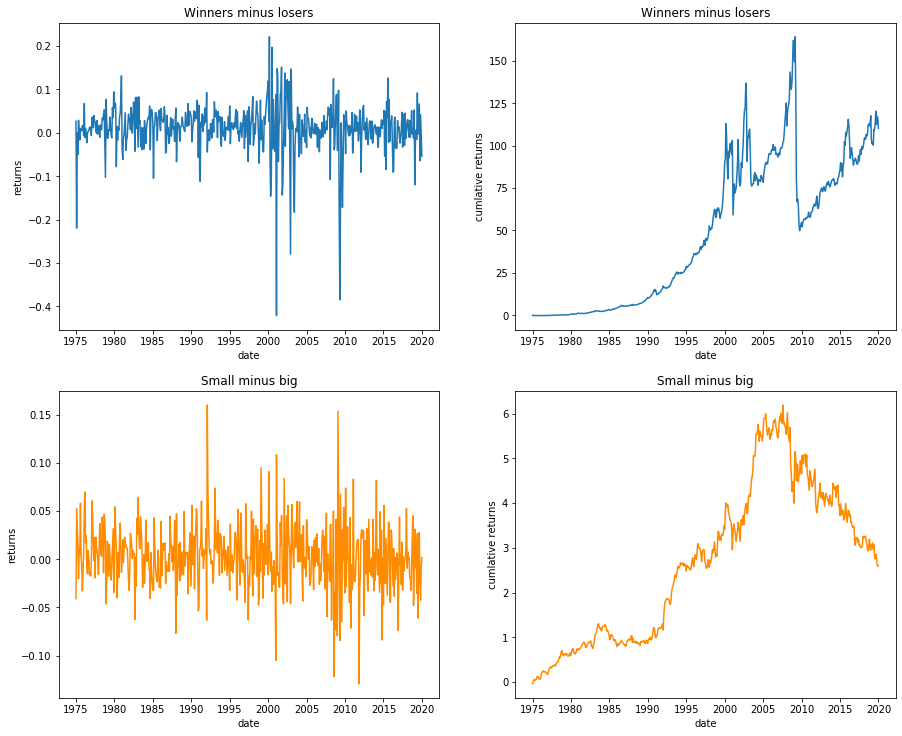

In [54]:
# Plot returns
fig, axs = plt.subplots(2, 2, figsize = (15,5))
axs[0, 0].plot(final['date'], final['wml'])
axs[0, 0].set_xlabel('date') 
axs[0, 0].set_ylabel('returns') 
axs[0, 0].set_title('Winners minus losers') 

axs[0, 1].plot(final['date'], (1 + final["wml"]).cumprod() - 1) 
axs[0, 1].set_xlabel('date') 
axs[0, 1].set_ylabel('cumlative returns') 
axs[0, 1].set_title('Winners minus losers') 

axs[1, 0].plot(final['date'], final['smb'], color = 'darkorange')
axs[1, 0].set_xlabel('date') 
axs[1, 0].set_ylabel('returns') 
axs[1, 0].set_title('Small minus big') 

axs[1, 1].plot(final['date'], (1 + final['smb']).cumprod() - 1, color = 'darkorange') 
axs[1, 1].set_xlabel('date') 
axs[1, 1].set_ylabel('cumlative returns') 
axs[1, 1].set_title('Small minus big') 

plt.subplots_adjust(top = 2)
plt.show()

In [50]:
# Correlation between factors
final['wml'].corr(final['smb'])

0.010571748596490457